# Stratigraphic interpretation of Badlands model outputs

This notebook allows to automatically interpret predicted stratigraphic architecture, using two stratigraphic methods:

- shoreline trajectory analysis ([Helland-Hansen & Hampson (2009)](http://onlinelibrary.wiley.com/wol1/doi/10.1111/j.1365-2117.2009.00425.x/full)) and
- accommodation succession method ([Neal & Abreu (2009)](https://www.researchgate.net/publication/249521744_Sequence_stratigraphy_hierarchy_and_the_accommodation_succession_method)).

<img src="images/Interpretation.png" alt="Interpretation methods"  width="780" height="400" border="10" />

For detailed explainations, please refer to [Ding et al., 2019](https://www.geosci-model-dev.net/12/2571/2019/).

To achieve this, we need to read successive outputs and calculate the **shoreline trajectory, changes in accommodation creation $\delta A$ and sedimentation $\delta S$**.

In [1]:
# opencv will be used to make animations. Uncomment the following line if you did not install opencv. 
# !pip install opencv-python

In [1]:
import cv2
import os
import numpy as np
import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.colors
import cmocean as cmo
from matplotlib import mlab, cm
import pandas as pd
from scipy.interpolate import interp1d

# Import the python file (.py) which contains all defined functions
from scripts import stratalInterpret as strata

# Display plots in SVG format
%config InlineBackend.figure_format = 'svg'

# Display plots in cells
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading successive stratigraphic files

In the delta example, 100 outputs are recorded (**`nbout=100`**). We use a loop to read the output every 5 timesteps (**`nstep=5`**).

To load the output files you will need to give the folder name and the number of processors used in your simulation.

In [2]:
folder = 'case3_aus/output_/h5'  # output folder path

# Read specific outputs
# outputID = np.array([1,   4,  49,  83,  93, 115, 126, 143, 146, 149]).astype(int) # in Myr or Ma

# Or read outputs with the same time step
nbout = 149  # time index of the last output that will be loaded
nstep = 10    # time step of reading multiple outputs
outputID = np.append(np.arange(0,nbout,nstep),nbout)
outputID[0
        ] = 1  # change the index of the first output from 0 to 1

# Time structure of the model, corresponding to the Time structure in the input.xml file
start_time = 0  # the start time of the model run [a]
dispTime = 5000  # the display time interval [a], can be obtained from the time structure in input.xml file
end_time = start_time + dispTime * nbout  # the time of the loaded output [a]

layTime = 2500  # the layer time interval [a], can be obtained from the strata structure in input.xml file
layID = outputID * (dispTime/layTime)

outputTime = start_time + outputID * dispTime
layerTime = start_time + layID * layTime

print 'Loaded output index: '+str(outputID)
print 'Corresponding to the time at: '+str(outputTime)+' years'

Loaded output index: [  1   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]
Corresponding to the time at: [  5000  25000  50000  75000 100000 125000 150000 175000 200000 225000
 250000 275000 300000 325000 350000 375000 400000 425000 450000 475000
 500000] years


In [3]:
# help(strata.stratalSection.__init__)
# help(strat.loadStratigraphy)

In [3]:
# Define an array to store the multiple outputs
strat_all = {}  

# Use a for loop to load multiple outputs
k = 0
for i in outputID:
    strat_all[k] = strata.stratalSection(folder,1)
    strat_all[k].loadStratigraphy(i)
    k += 1

# Also load TIN files at the last timestep 
strat_all[k-1].loadTIN(i)  

## Build cross-section for each stratigraphic layer

To build a cross-section to visualise the stratigraphic layers, you will need to provide:

+ the coordinates of two points **_(x1,y1)_** and **_(x2,y2)_** deliminating the cross-section, 
+ the number of points **_nbpts_** that defines the resolution of this cross-section and
+ a gaussian filter value **_gfilt_** to smooth the the stratigraphic layer, a value of 0 can be used for non-smoothing). 

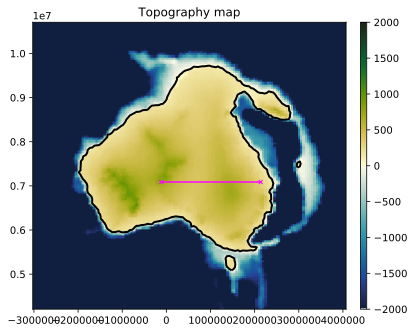

In [4]:
# Coordinates of two points on the cross-section
cs=np.zeros((2,2))
cs[0,:] = [2137110.46715,7087591.94151]  # point 1
cs[1,:] = [-112889.532847,7087591.94151]  # point 2

# Interpolation parameters
nbpts = 500  
gfilt = 2  

# Show the location of the cross-section on the final topography map
strat_all[k-1].plotSectionMap(title='Topography map', color=cmo.cm.delta, colorcs='magenta', crange=[-2000,2000], cs=cs, size=(6,6))

In [5]:
# help(strat.buildSection)

In [6]:
# Build cross-sections
nbcs = len(strat_all)  # number of outputs loaded. Build cross-section for each output.
for i in range(0,nbcs):
    strat_all[i].buildSection(xo = cs[0,0], yo = cs[0,1], xm = cs[1,0], ym = cs[1,1], pts = nbpts, gfilter = gfilt)  

## Visualize the stratal stacking pattern

We use **plotly** to visualise the vertival cross-section of stratal stacking pattern.

In [18]:
# help(strata.viewSection)

In [7]:
# Visualize the stratal stacking pattern at the last timestep
strata.viewSection(width = 800, height = 500, cs = strat_all[nbcs-1], dnlay = 2, 
                   rangeX=[0, 12000], rangeY=[-700,700], linesize = 0.5, title='Stratal stacking pattern coloured by time')

## Output stratal layers through time 

After reading successive outputs, you can create an animation that shows the stratal layers through time.

In [8]:
# First, make a directory to store the output images
!mkdir temporal_strata

# Plot the temporal stratal layers
strata.strataAnimate(width = 7, height = 3, cs = strat_all, nstep = nstep, time = layerTime, rangeX = [2000, 11000], 
                     rangeY = [-500,200], folder = 'temporal_strata')

mkdir: cannot create directory ‘temporal_strata’: File exists


In [9]:
image_folder = 'temporal_strata'
video_name = 'temporal_strata/aus_strataAnimate.avi'

# Load images
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

# Sort out images in case they are not in order
for infile in sorted(images): 
    video.write(cv2.imread(os.path.join(image_folder, infile)))

cv2.destroyAllWindows()
video.release()

## Read sea level file

To calculate the temporal shoreline position, and the accommodation change and sedimentation rate at the shoreline through time, we need to load the sea level file from the /data folder.

In [18]:
# Folder path of the sea level file
SLfolder = 'case3_aus/data/sea.csv'  
SLtime, sealevel = strata.readSea(SLfolder)
 
# View sea level curve
strata.viewData(x0 = SLtime, y0 = sealevel, width = 800, height = 500, linesize = 3, 
                color = '#6666FF',title='Sea level curve',xlegend='Time [yr]',ylegend='Sea level position [m]')

**Note**

The time interval of sea level and the time interval of sedimentary layers can be different. Therefore, we need to extract the sea level value for each sedimentary layer.

In [19]:
# Interpolate sea level
interpolatedSeaLevel = interp1d(SLtime, sealevel, kind='linear')
layer_SL = interpolatedSeaLevel(outputTime)

strata.viewData(x0 = outputTime, y0 = layer_SL, width = 800, height = 500, linesize = 3, 
                color = '#6666FF',title='Sea level curve',xlegend='Time [yr]',ylegend='Sea level position [m]')

## Calculate shoreline trajectory, $\delta A$ and $\delta S$

* shoreline position at a specific time is defined as the position whose elevation equals to the sea level at that time;
* $\delta A$ is calculated as changes in water depth at the shoreline; $\delta S$ is calculated as sedimentation rate at the shoreline.

In [12]:
# help(strat.buildParameters)

In [13]:
strat_all[0].buildParameters(CS = strat_all, Sealevel = layer_SL)

# 1- Shoreline trajectory analysis 

In [14]:
# Visualize the shoreline trajectory (migration of shoreline positions through time)
xval = outputTime
shoreline_pos = strat_all[0].dist[strat_all[0].shoreID]

# View shoreline position through time
strata.viewData(x0 = xval, y0 = shoreline_pos, width = 800, height = 500, linesize = 3, color = '#6666FF',
               title='Shoreline trajectory',xlegend='Time [yr]',ylegend='shoreline position in metres')

<img src="images/shoreTrajectory.png" alt="Interpretation methods"  width="800" height="400" border="10" />

IndexError: list index out of range

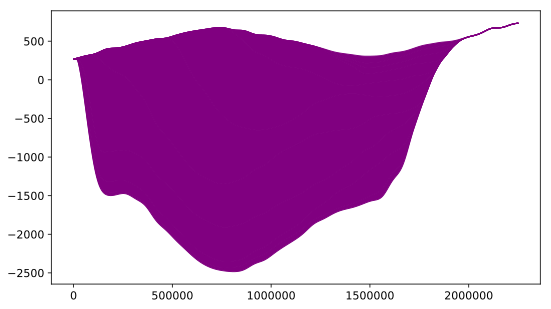

In [15]:
# Default color used: 
TTC = 'royalblue'
DRTC = 'mediumseagreen'  
ARTC = 'sandybrown'
STC = 'purple'

# Build a color list for the defined shoreline trajectory classes
STcolors_ST = strata.build_ShoreTrajectory(shoreline = shoreline_pos, sealevel = layer_SL, 
                                           cTTC=TTC, cDRTC=DRTC, cARTC=ARTC, cSTC=STC)

# Visualise the defined shoreline trajectory classes
strata.viewSystemsTracts(width = 8, height = 5, cs = strat_all[nbcs-1], layID = layID, dnlay = nstep, 
                       color = STcolors_ST, rangeX=[2000, 11000], rangeY=[-400,200], 
                       savefig = 'Yes', figname = 'delta_shoreline_interp')

# 2- Accommodation succession analysis

In [ ]:
# Visualise the difference between the rate of accommodation change and the sedimentation rate (dA-dS)
xval = outputTime
ASval = np.array(strat_all[0].accom_shore)-np.array(strat_all[0].sed_shore)

# Accommodation (A) and sedimentation (S) change differences
strata.viewData(x0 = xval, y0 = ASval, width = 800, height = 500, linesize = 3, 
                color = '#6666FF',title='Change between accomodation & sedimentation',xlegend='Time [yr]',
                ylegend='A-S')

<img src="images/accomAnalysis.png" alt="Interpretation methods"  width="700" height="400" border="10" />

In [ ]:
# Default color used: 
R = 'royalblue' 
PA = 'orange' 
APD= 'green'

# Build a color list for the defined accommodation succession sequence sets
STcolors_AS = strata.build_AccomSuccession(ASval = ASval, cR=R, cPA=PA, cAPD=APD)

# Visualise the defined accommodation succession sequence sets
strata.viewSystemsTracts(width = 8, height = 5, cs = strat_all[nbcs-1], layID = layID, dnlay = nstep, 
                       color = STcolors_AS, rangeX=[2000, 11000], rangeY=[-400,200], 
                       savefig = 'Yes', figname = 'delta_AS_interp')